C:\Users\Tom Li\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


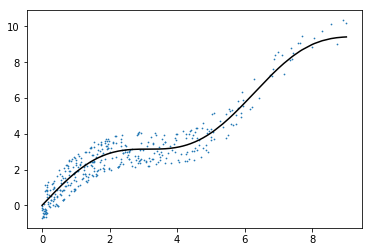

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Data
n = 20000
x = np.linspace(0,10,n)

# Drop data points
#p = abs(np.sin(x))
p = (x/max(x))**0.02
r = np.random.uniform(0,1,n)
x = x[r>p]

n = len(x)

epis = np.random.uniform(-1,1,n)
#y = np.sin(x + epis * (x/1)**1)
#y = np.sin(x + epis)
#y = (x + epis) + x**1.5
y_true = x + np.sin(x)
y = y_true + epis
#y = y*1

plt.scatter(x, y, s = 0.5)
plt.plot(x, y_true, c = 'black')

(array([103.,  83.,  59.,  46.,  33.,  28.,  20.,   9.,   9.,   5.]),
 array([0.        , 0.90154508, 1.80309015, 2.70463523, 3.60618031,
        4.50772539, 5.40927046, 6.31081554, 7.21236062, 8.1139057 ,
        9.01545077]),
 <a list of 10 Patch objects>)

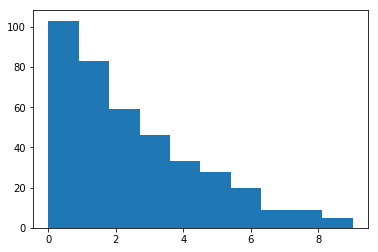

In [2]:
x = x.reshape(n, 1)
x.shape
plt.hist(x)

In [3]:
# Network parameter
n_inputs = 1
n_hidden1 = 10
n_hidden2 = 10
n_outputs = 1

## Non-Bayesian

In [4]:
# tf Graph input
X_tf = tf.placeholder(tf.float32,
                  shape = (None, n_inputs),
                  name = 'X')
y_tf = tf.placeholder(tf.float32,
                  shape = (None),
                  name = 'y')

# Paraameters
learning_rate = 0.1
num_steps = 10000
batch_size = 100
display_step = 500

# Layer weights and bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_inputs, n_hidden1])),
    'h2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_hidden2, n_outputs])), 
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden1])),
    'b2': tf.Variable(tf.random_normal([n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_outputs])), 
}

# Model
def neural_net(x):
    # Hidden fully connected
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    #layer_1 = tf.nn.dropout(layer_1, keep_prob=0.8)
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    #layer_2 = tf.nn.dropout(layer_2, keep_prob=0.8)
    # Output
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    
    return out_layer

In [5]:
# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# Evaluate model

# Initialize the variables
init = tf.global_variables_initializer()

In [6]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        #batch_x = np.random.choice(x[:,0], batch_size).reshape(batch_size, 1)
        #batch_y = np.random.choice(y, batch_size)
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred = sess.run(NN, feed_dict={X_tf: x})


step 1, Minibatch Loss = 42.24202
step 500, Minibatch Loss = 0.6276624
step 1000, Minibatch Loss = 0.5181897
step 1500, Minibatch Loss = 0.47388142
step 2000, Minibatch Loss = 0.43034756
step 2500, Minibatch Loss = 0.39314112
step 3000, Minibatch Loss = 0.36559853
step 3500, Minibatch Loss = 0.35211885
step 4000, Minibatch Loss = 0.34501547
step 4500, Minibatch Loss = 0.34345335
step 5000, Minibatch Loss = 0.34198084
step 5500, Minibatch Loss = 0.34160838
step 6000, Minibatch Loss = 0.3414938
step 6500, Minibatch Loss = 0.34143957
step 7000, Minibatch Loss = 0.34137645
step 7500, Minibatch Loss = 0.34129453
step 8000, Minibatch Loss = 0.34119383
step 8500, Minibatch Loss = 0.3410638
step 9000, Minibatch Loss = 0.3409073
step 9500, Minibatch Loss = 0.34070688
step 10000, Minibatch Loss = 0.34047467
optimization finished


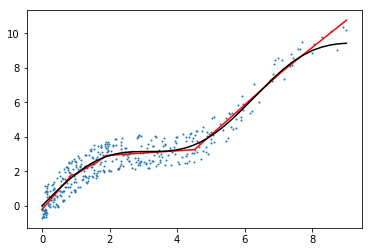

In [7]:
plt.scatter(x, y, s = 1)
plt.plot(x, pred, c = 'r')
plt.plot(x, y_true, c = 'black')

## Bayesian

In [20]:
neural_net = tf.keras.Sequential([
    tfp.layers.DenseFlipout(n_hidden1, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(n_hidden2, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(n_outputs),
])

# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
neg_log_likelihood  = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))

kl = sum(neural_net.losses)/n
loss_op = neg_log_likelihood + kl

optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# Initialize the variables
init = tf.global_variables_initializer()

In [21]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred_mean = sess.run(NN, feed_dict={X_tf: x})
    
    # Draw sample for the weights and bias from the posterior
    n_sample = 100
    w0_draw = neural_net.layers[0].kernel_posterior.sample(n_sample).eval()
    w1_draw = neural_net.layers[1].kernel_posterior.sample(n_sample).eval()
    w2_draw = neural_net.layers[2].kernel_posterior.sample(n_sample).eval()
    b0_draw = neural_net.layers[0].bias_posterior.sample(n_sample).eval()
    b1_draw = neural_net.layers[1].bias_posterior.sample(n_sample).eval()
    b2_draw = neural_net.layers[2].bias_posterior.sample(n_sample).eval()



step 1, Minibatch Loss = 11.05765
step 500, Minibatch Loss = 1.473813
step 1000, Minibatch Loss = 1.4322453
step 1500, Minibatch Loss = 1.2833073
step 2000, Minibatch Loss = 1.2030834
step 2500, Minibatch Loss = 1.0529722
step 3000, Minibatch Loss = 0.87374496
step 3500, Minibatch Loss = 0.74610376
step 4000, Minibatch Loss = 0.75319993
step 4500, Minibatch Loss = 0.7146408
step 5000, Minibatch Loss = 0.6325445
step 5500, Minibatch Loss = 0.64803076
step 6000, Minibatch Loss = 0.5992509
step 6500, Minibatch Loss = 0.58657014
step 7000, Minibatch Loss = 0.5746062
step 7500, Minibatch Loss = 0.54215
step 8000, Minibatch Loss = 0.57558405
step 8500, Minibatch Loss = 0.533498
step 9000, Minibatch Loss = 0.52933884
step 9500, Minibatch Loss = 0.5580802
step 10000, Minibatch Loss = 0.5317679
optimization finished


In [22]:
def np_relu(x):
    return np.maximum(x, 0)

pred = []
for i in range(n_sample):
    pred.append(np_relu(np_relu(x.dot(w0_draw[i])+b0_draw[i]).dot(w1_draw[i])+b1_draw[i]).dot(w2_draw[i])+b2_draw[i])

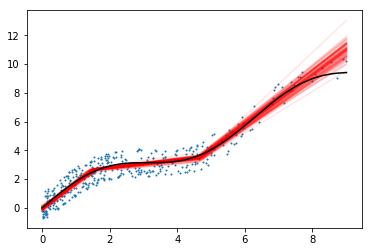

In [25]:
plt.scatter(x, y, s = 1)
for i in range(n_sample):
    plt.plot(x, pred[i], c = 'r', alpha = 0.1)
plt.plot(x, y_true, c = 'black')
#plt.plot(x, pred_mean, c = 'g')



